# Neural style transfer

This notebook is an assignment of fast.ai lesson8.
- http://forums.fast.ai/t/lesson-8-homework-assignments/1629

Neural Style Transfer is based on [this paper](https://arxiv.org/abs/1508.06576v2).

## Steps needed for Style Transfer using VGG:
### Content extraction

- Read the cont_image
- Resize cont_image
- Preprocess : RGB ->BGR and normalize
- Create VGG_avg
- Generate P(l) = activations for the cont_image at layer l
- Generate F(l) = activations for white noise image at layer l
- content_loss = MSE(P(l), F(l))

### Style extraction
- Read the style_image
- Resize style_image
- Preprocess : RGB ->BGR and normalize
- Create VGG_avg
- Generate Gram_matrix for original image, A(L) = Inner product of F * Ft for the layers L, where F is the vectorized feature map. (There is some weight to the loss for each layer?)
- Generate Gram_matrix for white noise image, G(L) similarly above
- style_loss = MSE(A(L), G(L))

### Style transfer
- loss(c,s,x) = a * content_loss(c, x) + b * style_loss(s, x), where c = content image, s = style image, x = generated image
- Use scipy's implementation of L-BFGS2 to find the values of "x" that minimize the loss (fmin_l_bfgs_b(loss, x0=x, args=(c, s))). In our case, "x" happens to be image pixels, and thus we end up searching for the image that is close to both the content image (c) and the style image (s).


## Setup
京都、嵐山の渡月橋。
- https://en.wikipedia.org/wiki/Arashiyama

In [8]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

In [2]:
# Tell Tensorflow to use no more GPU RAM than necessary
limit_mem()

In [24]:
path = '/home/tsu-nera/repo/fastai/deeplearning2'

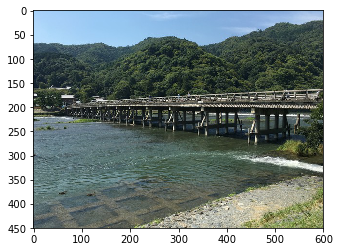

In [25]:
img=Image.open(path+'/data/bridge.jpg')
plt.imshow(np.array(img))

In [14]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [15]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [16]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

## Recreate Content 

In [18]:
model = VGG16_Avg(include_top=False)

In [19]:
layer = model.get_layer('block5_conv1').output

In [20]:
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

In [21]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [22]:
loss = metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

In [ ]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave(f'{path}/results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

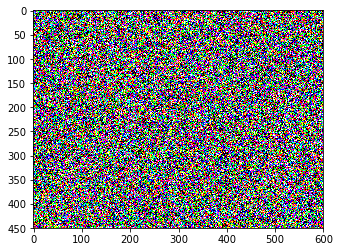

In [26]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(x[0]);

In [28]:
iterations=10

In [30]:
x = solve_image(evaluator, iterations, x)

Current loss value: 49.185092926
Current loss value: 11.1849546432


KeyboardInterrupt: 

In [33]:
Image.open(path + '/results/res_at_iteration_9.png')

FileNotFoundError: [Errno 2] No such file or directory: '/home/tsu-nera/repo/fastai/deeplearning2/results/res_at_iteration_9.png'

In [ ]:
from IPython.display import HTML
from matplotlib import animation, rc

In [ ]:
fig, ax = plt.subplots()
def animate(i): ax.imshow(Image.open(f'{path}/results/res_at_iteration_{i}.png'))

## Recreate style

In [ ]:
def plot_arr(arr): plt.imshow(deproc(arr,arr.shape)[0].astype('uint8')

In [ ]:
style = Image.open(path+'/data/starry_night.jpg')

In [ ]:
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])
shp = style_arr.shape

In [ ]:
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

In [ ]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]

In [ ]:
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

In [ ]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [ ]:
def style_loss(x, targ):
    return metrics.mse(gram_matrix(x), gram_matrix(targ))

In [ ]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

In [ ]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])

In [ ]:
plt.imshow(x[0])

In [ ]:
iterations=10
x = rand_img(shp)

In [ ]:
x = solve_image(evaluator, iterations, x)

In [34]:
Image.open(path + 'results/res_at_iteration_9.png')

FileNotFoundError: [Errno 2] No such file or directory: '/home/tsu-nera/repo/fastai/deeplearning2results/res_at_iteration_9.png'

## Style transfer

In [36]:
w,h = style.size
src = img_arr[:,:h,:w]
plot_arr(src)

NameError: name 'style' is not defined

In [38]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]

NameError: name 'outputs' is not defined

In [37]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

NameError: name 'style_layers' is not defined

In [39]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

NameError: name 'content_layer' is not defined

In [40]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [41]:
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2,w in zip(style_layers, style_targs, style_wgts))
loss += metrics.mse(content_layer, content_targ)/10
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

NameError: name 'style_layers' is not defined

In [42]:
evaluator = Evaluator(transfer_fn, shp)

NameError: name 'transfer_fn' is not defined

In [43]:
iterations=10
x = rand_img(shp)

In [44]:
x = solve_image(evaluator, iterations, x)

KeyboardInterrupt: 

In [ ]:
Image.open(path + 'results/res_at_iteration_9.png')